In [ ]:
testdir = '/content/drive/MyDrive/Forest Fire Dataset/Testing'
traindir = '/content/drive/MyDrive/Forest Fire Dataset/Training'

import matplotlib.pyplot as plt
import matplotlib.image as img
import keras 
import numpy as np

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        traindir,
        target_size = (height, width),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        testdir,
        target_size = (height, width), 
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [ ]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [ ]:
from keras.applications import VGG19
conv_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from keras.applications.vgg19 import preprocess_input
train_dataset, val_dataset = generators((224,224), preprocessing=preprocess_input)

Found 1377 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [ ]:
train_dataset.class_indices

{'fire': 0, 'nofire': 1}

In [ ]:
val_dataset.class_indices

{'fire': 0, 'nofire': 1}

In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
44/44 [==============================] - 12s 239ms/step - loss: 0.1845 - acc: 0.9666 - val_loss: 0.0253 - val_acc: 0.9737
Epoch 2/5
44/44 [==============================] - 11s 238ms/step - loss: 0.0231 - acc: 0.9942 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 3/5
44/44 [==============================] - 12s 241ms/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4/5
44/44 [==============================] - 12s 242ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 5/5
44/44 [==============================] - 11s 242ms/step - loss: 4.8318e-04 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000


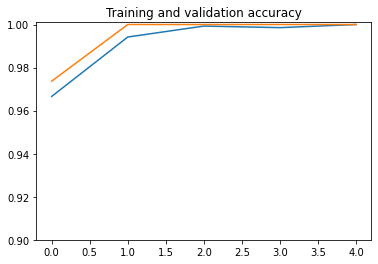

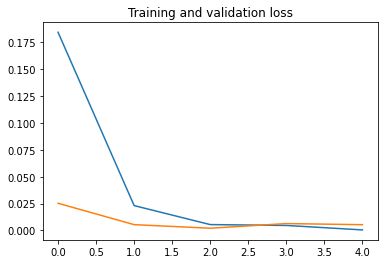

In [ ]:
plot_history(history, yrange=(0.9,1.001))

1/1 [==============================] - 0s 20ms/step
[[3.254368e-08 1.000000e+00]]


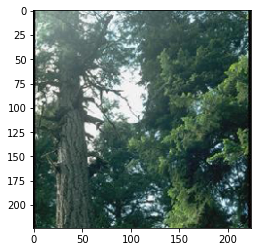

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

img_path = '/content/drive/MyDrive/Forest Fire Dataset/Testing/nofire/nofire_0039.jpg'
img = image.image_utils.load_img(img_path, target_size=(224,224))
x = image.image_utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
plt.imshow(img)

In [ ]:
import sys

def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,2))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = full_model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

In [ ]:
train_labels, train_preds = true_and_predicted_labels(train_dataset)

1/1 [==============================] - 0s 33ms/step


In [ ]:
full_model.save('vgg19.h5')

In [ ]:
def plot_cat_score(preds, labels, range=(0,1)):
    # get the cat score for all images
    cat_score = preds[:,1]
    # get the cat score for dogs
    # we use the true labels to select dog images
    dog_cat_score = cat_score[labels[:,0]>0.5]
    # and for cats
    cat_cat_score = cat_score[labels[:,0]<0.5]
    # just some plotting parameters
    params = {'bins':100, 'range':range, 'alpha':0.6}
    plt.hist(dog_cat_score, **params)
    plt.hist(cat_cat_score, **params)
    plt.yscale('log')

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


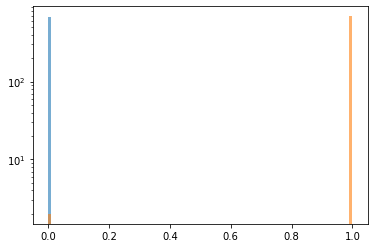

In [ ]:
plot_cat_score(train_preds, train_labels)